# Домашнее задание.

1. Произвести обучение модели для сегментации ногтей на фотографии. За основу модели взять архитектуру U-Net из урока.
2. Информацию об обучении необходимо вывести в Tensorboard.
3. Подобрать параметры оптимизатора (learning rate), а также количество эпох для достижения наилучшего соотношения "качество предсказания / время обучения"



In [27]:
# 1. Произвести обучение модели для сегментации ногтей на фотографии. 
# За основу модели взять архитектуру U-Net из урока.

import tensorflow as tf
import tensorflow.keras as K
import random
from itertools import islice
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.callbacks import TensorBoard

In [38]:
def unet(input_shape):
    inp = K.Input(input_shape)
    
    conv1 = K.layers.Conv2D(64,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(inp)
    conv1 = K.layers.Conv2D(64,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = K.layers.MaxPool2D(pool_size=(2, 2))(conv1)
    
    conv2 = K.layers.Conv2D(128,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = K.layers.Conv2D(128,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = K.layers.MaxPool2D(pool_size=(2, 2))(conv2)
    
    conv3 = K.layers.Conv2D(256,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = K.layers.Conv2D(256,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = K.layers.MaxPool2D(pool_size=(2, 2))(conv3)
    
    conv4 = K.layers.Conv2D(512,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = K.layers.Conv2D(512,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = K.layers.MaxPool2D(pool_size=(2, 2))(conv4)
    
    conv5 = K.layers.Conv2D(1024,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = K.layers.Conv2D(1024,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(conv5)
    #dropout must be there!
    upconv6 = K.layers.UpSampling2D(size=(2,2))(conv5)
    data_concat = K.layers.concatenate([upconv6, conv4], axis = 3)
    conv6 = K.layers.Conv2D(512,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(data_concat)
    conv6 = K.layers.Conv2D(512,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(conv6)
    
    upconv7 = K.layers.UpSampling2D(size=(2,2))(conv6)
    data_concat = K.layers.concatenate([upconv7, conv3], axis = 3)
    conv7 = K.layers.Conv2D(256,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(data_concat)
    conv7 = K.layers.Conv2D(256,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(conv7)
    
    upconv8 = K.layers.UpSampling2D(size=(2,2))(conv7)
    data_concat = K.layers.concatenate([upconv8, conv2], axis = 3)
    conv8 = K.layers.Conv2D(128,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(data_concat)
    conv8 = K.layers.Conv2D(128,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(conv8)
    
    upconv9 = K.layers.UpSampling2D(size=(2,2))(conv8)
    data_concat = K.layers.concatenate([upconv9, conv1], axis = 3)
    conv9 = K.layers.Conv2D(64,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(data_concat)
    conv9 = K.layers.Conv2D(64,(3, 3),activation = 'relu',padding='same', kernel_initializer='he_normal')(conv9)
    
    #conv10 = K.layers.Conv2D(2,3,activation = 'relu',padding='same', kernel_initializer='he_normal')(conv9)
    # conv10 = K.layers.Conv2D(1,(3,3),activation = 'sigmoid', padding='same')(conv9)
    conv10 = K.layers.Conv2D(1, (1, 1),activation = 'sigmoid')(conv9) 
    
    model = K.Model(inp, conv10)
    model.compile(optimizer = K.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [53]:
K.backend.clear_session()
IMG_SIZE = 256
model = unet([IMG_SIZE, IMG_SIZE, 3])
model.compile(optimizer = K.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[K.metrics.MeanIoU(num_classes=2)])

In [40]:
path_to_images = 'nails_segmentation\images'

names = os.listdir(path_to_images)

list_of_pairs = []

for n in names:
    path_to_labels = 'nails_segmentation\labels\\' + n
    path_to_images = 'nails_segmentation\images\\' + n
    list_of_pairs.append([path_to_images, path_to_labels])

In [41]:
def aug(img, label):
    h, w, d = img.shape
    
#    Поворот на случайный угол
    if random.random() > 0.5:
        center = (w // 2, h // 2)
        angle = random.randint(-90,90)
        M = cv2.getRotationMatrix2D(center, angle, 1)  # Указывается центр, угол поворота, масштаб
        img = cv2.warpAffine(img, M, (h,w))
        label = cv2.warpAffine(label, M, (h,w))
        
#    Отражение по вертикали, горизонтали
    if random.random() > 0.5:
        if random.random() > 0.5:
            img = cv2.flip(img, 1) # horizontal flip
            label = cv2.flip(label, 1)
        else:
            img = cv2.flip(img, 0) # vertical flip
            label = cv2.flip(label, 0)
    
#    Размытие.
    if random.random() > 0.5:
        kernel = (random.randint(1,10), random.randint(1,10))
        img = cv2.blur(img, kernel)
        label = cv2.blur(label, kernel)
    
    return img, label

In [43]:
def generator_with_aug(data, size):
    images = []
    labels = []
    d = data.copy()
    random.shuffle(d)
    count = 0
    for x, y in d:        
        img = cv2.imread(x)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        lb = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        #lb = cv2.cvtColor(lb, cv2.COLOR_BGR2RGB)

        if random.random() > 0.5: 
            img, lb = aug(img, lb)
        
        img = cv2.resize(img, (256, 256))
        lb = cv2.resize(lb, (256, 256))
        img = img / 255.
        lb = lb / 255.
        
        lb = lb[...,None]
        
        images.append(img)
        labels.append(lb)
        count = count + 1
        if count % size == 0:
            mask_array=np.array(labels,np.float32)
            img_array=np.array(images,np.float32)
            yield img_array, mask_array
            images = []
            labels = []

In [44]:
def test_and_val_data_generator(data, size):
    images = []
    labels = []
    d = data.copy()
    random.shuffle(d)
    count = 0
    for x, y in d:        
        img = cv2.imread(x)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        lb = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        #lb = cv2.cvtColor(lb, cv2.COLOR_BGR2RGB)
        
        img = cv2.resize(img, (256, 256))
        lb = cv2.resize(lb, (256, 256))
        
        img = img / 255.
        lb = lb / 255.
        
        lb = lb[...,None]
        
        images.append(img)
        labels.append(lb)
        count = count + 1
        if count % size == 0:
            mask_array=np.array(labels,np.float32)
            img_array=np.array(images,np.float32)
            yield img_array, mask_array
            images = []
            labels = []

In [61]:
print(len(list_of_pairs))
VAL_IMGS_NUM = 8
TRAIN_IMNGS_NUM = len(list_of_pairs) - VAL_IMGS_NUM

train_imgs_path = list_of_pairs[:-VAL_IMGS_NUM]
val_imgs_paths = list_of_pairs[-VAL_IMGS_NUM:]

f"train: {TRAIN_IMNGS_NUM}; val: {VAL_IMGS_NUM}"

52


'train: 44; val: 8'

(256, 256, 3)
(256, 256, 1)


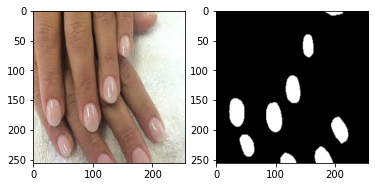

In [63]:
for x_train, y_train in generator_with_aug(train_imgs_path, 5):
    print(x_train[0].shape)
    print(y_train[0].shape)
    break

plt.subplot(1,2,1)    
plt.imshow(x_train[0])   
plt.subplot(1,2,2)  
plt.imshow(y_train[0], cmap='gray') 
plt.show()

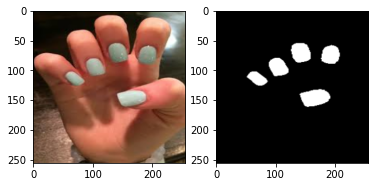

In [65]:
for x_val, y_val in test_and_val_data_generator(val_imgs_paths, len(val_imgs_paths)):
    print(x_val[0].shape)
    print(y_val[0].shape)
    break
    
plt.subplot(1,2,1)    
plt.imshow(x_val[2])   
plt.subplot(1,2,2)  
plt.imshow(y_val[2], cmap='gray') 
plt.show()    

In [66]:
def train_generator(batch_size, epochs):
    for _ in range(epochs):
        data_generator = generator_with_aug(train_imgs_path, batch_size)
        yield from data_generator

In [76]:
batch_size = 4
epochs = 3
steps_per_epoch = TRAIN_IMNGS_NUM // batch_size

history = model.fit(train_generator(batch_size, epochs),
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs) 

Epoch 1/3
11/11 [==============================] - 144s 13s/step - loss: 0.1849 - mean_io_u: 0.4793
Epoch 2/3
11/11 [==============================] - 149s 14s/step - loss: 0.1864 - mean_io_u: 0.4797
Epoch 3/3
11/11 [==============================] - 151s 14s/step - loss: 0.1795 - mean_io_u: 0.4802


In [77]:
for x_test, y_test in test_and_val_data_generator(test_data, len(test_data)):
    print(x_test[0].shape)
    print(y_test[0].shape)
    break
    
y_pred = model.predict(x_test) 

(256, 256, 3)
(256, 256, 1)


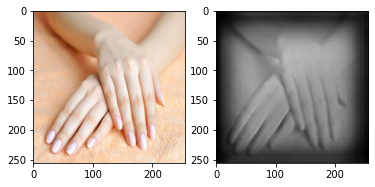

In [78]:
plt.subplot(1,2,1)    
plt.imshow(x_test[1])   
plt.subplot(1,2,2)  
plt.imshow(y_pred[1],cmap='gray') 
plt.show()  

In [79]:
epochs = 50

# Стартуем с предыдущей эпохи (особенно важно, если у вас как то зависят параметры оптимизатора от номера эпохи)
# Также должна правильно обновляться история и производиться логнирование в TensorBoard
prev_epoch = history.epoch[-1] + 1

history = model.fit(
    train_generator(batch_size, epochs),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs + prev_epoch,  # prev_epoch уже пройдено, и ещё новых epochs
    initial_epoch=prev_epoch,  # непосредственно указание, что prev_epoch пройдено
)

Epoch 4/53
11/11 [==============================] - 140s 13s/step - loss: 0.1794 - mean_io_u: 0.4803
Epoch 5/53
11/11 [==============================] - 143s 13s/step - loss: 0.1626 - mean_io_u: 0.4791
Epoch 6/53
11/11 [==============================] - 147s 13s/step - loss: 0.1769 - mean_io_u: 0.4790
Epoch 7/53
11/11 [==============================] - 149s 14s/step - loss: 0.1783 - mean_io_u: 0.4806
Epoch 8/53
11/11 [==============================] - 149s 13s/step - loss: 0.1624 - mean_io_u: 0.4790
Epoch 9/53
11/11 [==============================] - 150s 14s/step - loss: 0.1520 - mean_io_u: 0.4796
Epoch 10/53
11/11 [==============================] - 150s 14s/step - loss: 0.1455 - mean_io_u: 0.4792
Epoch 11/53
11/11 [==============================] - 150s 14s/step - loss: 0.1400 - mean_io_u: 0.4802
Epoch 12/53
11/11 [==============================] - 149s 14s/step - loss: 0.1400 - mean_io_u: 0.4798
Epoch 13/53
11/11 [==============================] - 149s 14s/step - loss: 0.1527 - mean

In [80]:
y_pred = model.predict(x_test) 
# y_pred = model.predict(x_train[:4]) 

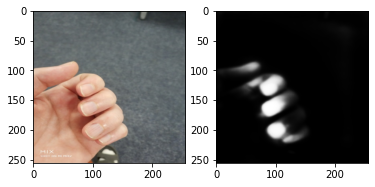

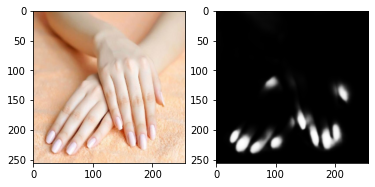

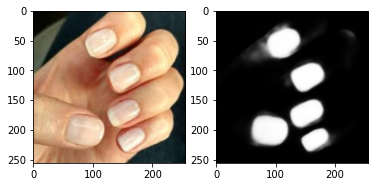

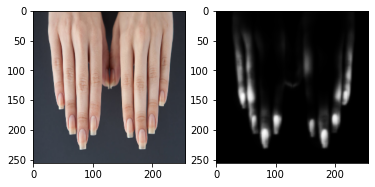

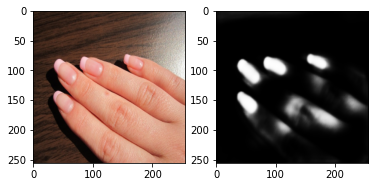

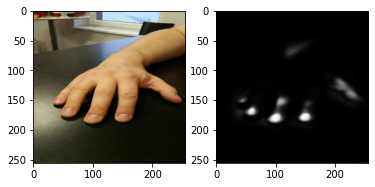

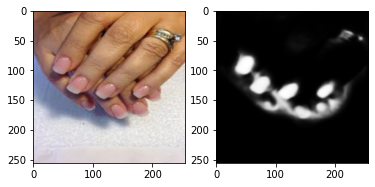

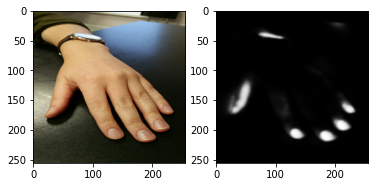

In [91]:
for i in range(8):
    plt.subplot(1,2,1)    
    plt.imshow(x_test[i])
    # plt.imshow(x_train[1])   
    plt.subplot(1,2,2)  
    plt.imshow(y_pred[i],cmap='gray') 
    plt.show() 

In [88]:
tensorboard_callback = TensorBoard(log_dir='./logs/Unet', histogram_freq=1)
# 

epochs = 10

# Стартуем с предыдущей эпохи (особенно важно, если у вас как то зависят параметры оптимизатора от номера эпохи)
# Также должна правильно обновляться история и производиться логнирование в TensorBoard
prev_epoch = history.epoch[-1] + 1

history = model.fit(
    train_generator(batch_size, epochs),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs + prev_epoch,  # prev_epoch уже пройдено, и ещё новых epochs
    initial_epoch=prev_epoch,  # непосредственно указание, что prev_epoch пройдено
    callbacks=[tensorboard_callback]
)

NameError: name 'TensorBoard' is not defined